In [1]:
import preprocessing.preprocessing as pp
import torch
from models import nodeClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from visualization import mesh_viewer
import evaluation.evaluation as ev
import graph_matching.graph_matching as gm
import graph_matching.graph_connection as gc
import training.training as tt
from sklearn.metrics import accuracy_score, balanced_accuracy_score
import pyvista

import tifffile as tiff
import networkx as nx
from torch_geometric.utils.convert import from_networkx
import wandb

# Create the graph from the combined masks and assign labels to it

In [2]:
# creating the graph
nodesFileComb =  "~/Documents/Intestine/combined-mask/nodes_bs2_fh.csv"
edgesFileComb = "~/Documents/Intestine/combined-mask/edges_bs2_fh.csv"

nodes_c = pd.read_csv(nodesFileComb, sep = ";", index_col= "id")
edges_c = pd.read_csv(edgesFileComb, sep = ";", index_col= "id")

# scaling with the factors provided by luciano
nodes_c = pp.scalePosition(nodes_c, (1.625,1.625,6))

# creating the graph
G_comb = pp.createGraph(nodes_c, edges_c)
G_comb_einf = pp.convertToEinfach(G_comb, self_loops = False, isolates = False)

### Assign the labels based on the masks

In [3]:
# base the classifcation on the mask labels at the position of the nodes
nerve_mask =  "../Intestine/nerve-mask/nerve_mask_stack_255_fh.tif"
lymph_mask =  "../Intestine/lymph-mask/lymph_mask_stack_255_fh.tif"

# read tif and convert to numpy 
nerve_mask_np = np.array(tiff.imread(nerve_mask)).T
lymph_mask_np = np.array(tiff.imread(lymph_mask)).T

# extracting the labels for the graph
mask_labels_num = gm.assignNodeLabelsByMask([nerve_mask_np, lymph_mask_np], G = G_comb_einf, voxel_size= (0.00217391,0.00217391,0.00217391), scaling_vector= (1.625, 1.625, 6), kernel_size=9)

# create dictionary to convert int labels to char labels
char_class_reverse = {}
char_class_reverse[0] = "n"
char_class_reverse[1] = "l"

# create a copy that will be used for relabeling
mask_labels = mask_labels_num.copy()

# adjust the node names
for key in mask_labels:
    mask_labels[key] = str(key) + char_class_reverse[mask_labels[key]]

# relabel the graph with the mask based labeling
G_comb_einf_lab = nx.relabel_nodes(G_comb_einf, mask_labels)
nx.write_gpickle(G_comb_einf_lab, "saved_data/graph_gt_pickle")

# check if all the masks have a label (otherwise class -1 exists)
np.unique(list(mask_labels_num.values()), return_counts = True)


100%|██████████| 3715/3715 [00:00<00:00, 35823.61it/s]


(array([0, 1]), array([1308, 2407]))

In [4]:
y_pos = [G_comb_einf.nodes[node]["pos"][1] for node in G_comb_einf.nodes()]
y_pos_sorted = sorted(y_pos)

x_pos = [G_comb_einf.nodes[node]["pos"][0] for node in G_comb_einf.nodes()]
z_pos = [G_comb_einf.nodes[node]["pos"][2] for node in G_comb_einf.nodes()]

print(max(x_pos))
print(min(x_pos))

print(max(y_pos))
print(min(y_pos))

print(max(z_pos))
print(min(z_pos))


y_pos_sorted[int(len(y_pos_sorted)*0.8)]

1.51077875
-1.6179345
1.105706875
-1.102174125
0.821742
-0.8478240000000001


0.628805125

### Visualize the graph

Dual graph from combined extraction with mask based labeling.


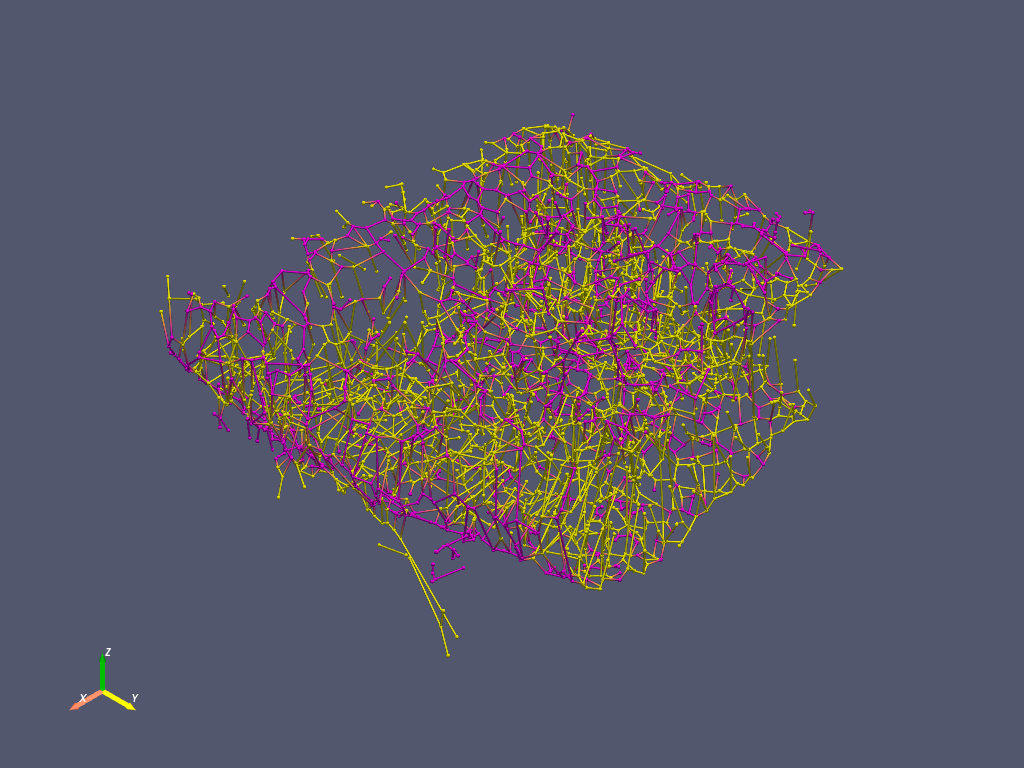

In [5]:
print("Dual graph from combined extraction with mask based labeling.")
mesh_viewer.renderNXGraph(G_comb_einf_lab, dual = False, vtk = 0,backend = "static")

### Create and visualize the dual graph

Dual graph from combined extraction with mask based labeling.


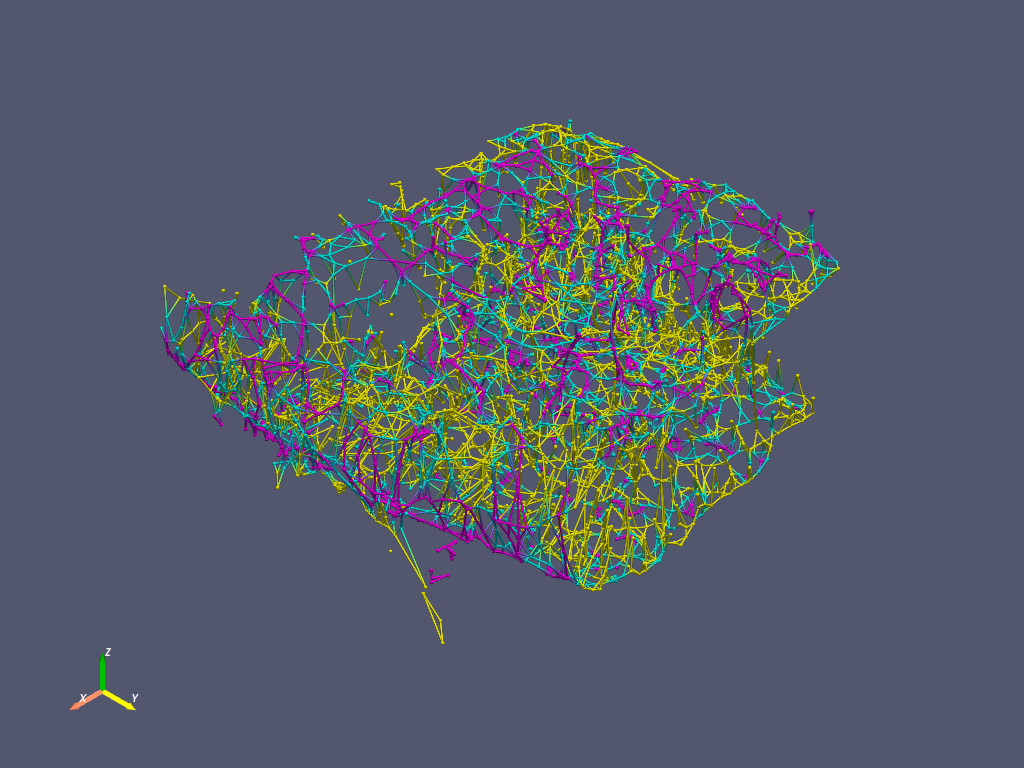

In [6]:
L_comb_einf_lab = pp.makeDual(G_comb_einf_lab, include_orientation= True)
print("Dual graph from combined extraction with mask based labeling.")
mesh_viewer.renderNXGraph(L_comb_einf_lab, dual = True, vtk = 0, backend = "static")

# Start playing with models for node classification

In [7]:
# loading potential architectures
netGCN = nodeClassifier.GCN_VS
netSAGE = nodeClassifier.SAGE_VS

### Classification on G

In [8]:
# enrich nodes with information form edges
pp.enrichNodeAttributes(G_comb_einf_lab)
GX_comb_einf_lab = from_networkx(G_comb_einf_lab)
GX_comb_einf_lab.y = torch.tensor(list(mask_labels_num.values()))


# extract the classes and features for model input
num_feat_comb = GX_comb_einf_lab.x.shape[1]
num_class_comb = len(np.unique(GX_comb_einf_lab.y))


# create a network arch
SAGE1 = nodeClassifier.nodeClassifier(netSAGE, 64, features = np.arange(num_feat_comb), classes = num_class_comb, num_layers= 4,  lr = 0.00134, weight_decay= 0.0002) 

# create a trainer for the model
# this way a random split is done
SAGE1_TR = tt.Trainer(SAGE1,GX_comb_einf_lab)


# create a trainer with slicing by z axis 
# slicing along any other axis than y does not really make sense - y slicing goes along the path of the intestine

SAGE1_TR_y = tt.Trainer(SAGE1,GX_comb_einf_lab, split= (0,1,0))


100%|██████████| 10/10 [00:02<00:00,  3.96it/s]


Total number of epochs: 10


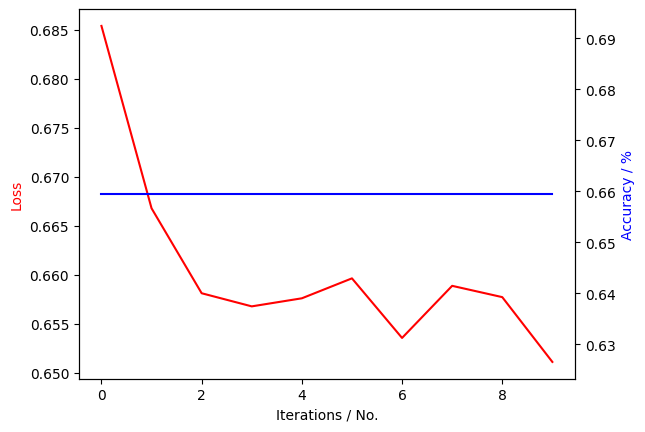

In [9]:
# train the model for a given number of epochs
loss_l, acc_l = SAGE1_TR.trainXepochs(10)

# total number of training epoch for this model
print("Total number of epochs: " + str(SAGE1_TR.totalEpoch))

# plot the loss and val acc over the epochs
ev.plot_loss_acc(loss_l, acc_l)

Validation set accuracy:  0.6595
Train set accuracy: 0.6450
Validation set balanced accuracy:  0.5000
Train set balanced accuracy: 0.5000


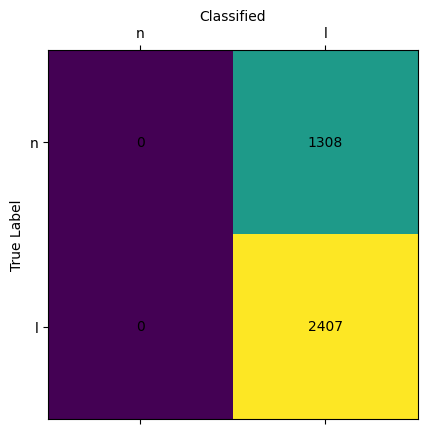

In [10]:
full_mask_comb = torch.tensor(np.arange(0, GX_comb_einf_lab.y.shape[0]))
pred_whole_comb = SAGE1_TR.model.predictions(GX_comb_einf_lab)
pred_whole_comb_acc = SAGE1_TR.model.test(GX_comb_einf_lab, full_mask_comb)


print(f"Validation set accuracy:  {accuracy_score(SAGE1_TR.nxGraph.y[SAGE1_TR.test_mask], pred_whole_comb[SAGE1_TR.test_mask]):.4f}")
print(f"Train set accuracy: {accuracy_score(SAGE1_TR.nxGraph.y[SAGE1_TR.train_mask], pred_whole_comb[SAGE1_TR.train_mask]):.4f}")

print(f"Validation set balanced accuracy:  {balanced_accuracy_score(SAGE1_TR.nxGraph.y[SAGE1_TR.test_mask], pred_whole_comb[SAGE1_TR.test_mask]):.4f}")
print(f"Train set balanced accuracy: {balanced_accuracy_score(SAGE1_TR.nxGraph.y[SAGE1_TR.train_mask], pred_whole_comb[SAGE1_TR.train_mask]):.4f}")
ev.plot_confusion_matrix(np.array(SAGE1_TR.nxGraph.y), pred_whole_comb, char_class_reverse.values())


# somehow this bugs
#rocL_comb = ev.eval_roc_auc(GX_comb_einf_lab.y, SAGE1_TR.model.predictions(GX_comb_einf_lab, max_prob = False))
#print("ROC AUC: " + str(rocL_comb))


### Classification on L

In [11]:
LX_comb_einf_lab = from_networkx(L_comb_einf_lab)
class_label_list, node_lab, node_lab_explain =  pp.getLablesForDual(L_comb_einf_lab)

# assign the ground truth class information to the torch data obj
LX_comb_einf_lab.y = torch.tensor(class_label_list)

# extract the number of classes and features for model input
num_feat_dual_comb = LX_comb_einf_lab.x.shape[1]
num_class_dual_comb = len(np.unique(LX_comb_einf_lab.y))

print(num_feat_dual_comb)
print(num_class_dual_comb)

# create a network arch
SAGE1L = nodeClassifier.nodeClassifier(netSAGE, 64, features = np.arange(num_feat_dual_comb), classes = num_class_dual_comb, num_layers= 8,  lr = 0.009076, weight_decay= 0.0001999) # prev  lr = 0.00542, weight_decay= 0.0001985

# create a trainer for the model
SAGE1L_TR = tt.Trainer(SAGE1L,LX_comb_einf_lab)


20
3


/home/laurin/.local/lib/python3.8/site-packages/torch_geometric/utils/convert.py:192: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:204.)
  data[key] = torch.tensor(value)


100%|██████████| 10/10 [00:05<00:00,  1.75it/s]

Total number of epochs: 10


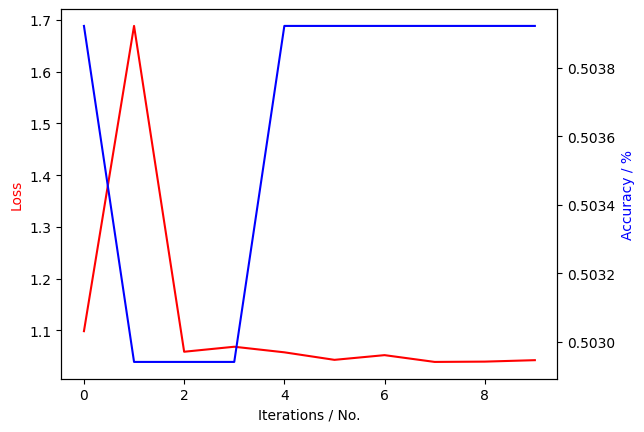

In [12]:
# train the model for a given number of epochs
loss_l, acc_l = SAGE1L_TR.trainXepochs(10)

# total number of training epoch for this model
print("Total number of epochs: " + str(SAGE1L_TR.totalEpoch))

# plot the loss and val acc over the epochs
ev.plot_loss_acc(SAGE1L_TR.loss_l, SAGE1L_TR.acc_l)

Validation set accuracy:  0.5039
Train set accuracy: 0.4985
Validation set balanced accuracy:  0.3333
Train set balanced accuracy: 0.3333


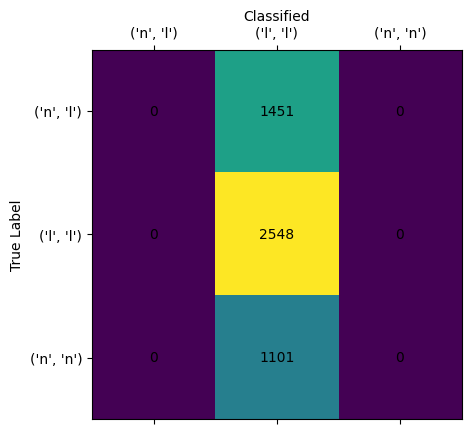

ROC AUC: 0.5524134445750627


In [13]:
full_mask_dual_comb = torch.tensor(np.arange(0, LX_comb_einf_lab.y.shape[0]))
pred_whole_comb = SAGE1L_TR.model.predictions(LX_comb_einf_lab)
pred_whole_comb_acc = SAGE1L_TR.model.test(LX_comb_einf_lab, full_mask_dual_comb)


print(f"Validation set accuracy:  {accuracy_score(SAGE1L_TR.nxGraph.y[SAGE1L_TR.test_mask], pred_whole_comb[SAGE1L_TR.test_mask]):.4f}")
print(f"Train set accuracy: {accuracy_score(SAGE1L_TR.nxGraph.y[SAGE1L_TR.train_mask], pred_whole_comb[SAGE1L_TR.train_mask]):.4f}")

print(f"Validation set balanced accuracy:  {balanced_accuracy_score(SAGE1L_TR.nxGraph.y[SAGE1L_TR.test_mask], pred_whole_comb[SAGE1L_TR.test_mask]):.4f}")
print(f"Train set balanced accuracy: {balanced_accuracy_score(SAGE1L_TR.nxGraph.y[SAGE1L_TR.train_mask], pred_whole_comb[SAGE1L_TR.train_mask]):.4f}")
ev.plot_confusion_matrix(np.array(SAGE1L_TR.nxGraph.y), pred_whole_comb, node_lab_explain.values())


# somehow this bugs
rocL_comb = ev.eval_roc_auc(LX_comb_einf_lab.y, SAGE1L_TR.model.predictions(LX_comb_einf_lab, max_prob = False))
print("ROC AUC: " + str(rocL_comb))


In [14]:
# save the model parameters
#torch.save(SAGE1L_TR.model.model.state_dict(), "saved_data/bestDualModel")


mLoad = nodeClassifier.SAGE_VS(in_channels = num_feat_dual_comb,hidden_channels= 64,out_channels = num_class_dual_comb, num_layers= 8, dropout = 0.5)
mLoad.load_state_dict(torch.load("saved_data/bestDualModel"))


# set the parameters to the safed ones
SAGE1L_TR.model.model = mLoad

RuntimeError: Error(s) in loading state_dict for SAGE_VS:
	size mismatch for convs.0.lin_l.weight: copying a param with shape torch.Size([64, 17]) from checkpoint, the shape in current model is torch.Size([64, 20]).
	size mismatch for convs.0.lin_r.weight: copying a param with shape torch.Size([64, 17]) from checkpoint, the shape in current model is torch.Size([64, 20]).

Validation set accuracy:  0.8686
Train set accuracy: 0.8978
Validation set balanced accuracy:  0.8633
Train set balanced accuracy: 0.8903


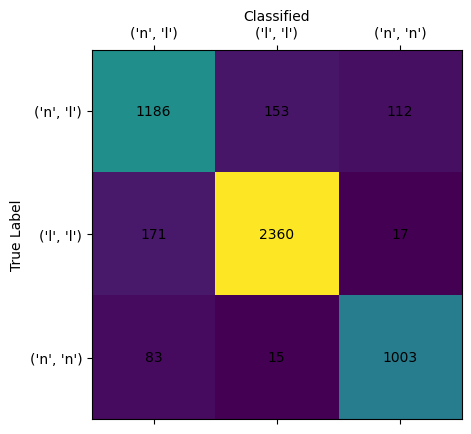

ROC AUC: 0.9702765235089231


In [ ]:
full_mask_dual_comb = torch.tensor(np.arange(0, LX_comb_einf_lab.y.shape[0]))
pred_whole_comb = SAGE1L_TR.model.predictions(LX_comb_einf_lab)
pred_whole_comb_acc = SAGE1L_TR.model.test(LX_comb_einf_lab, full_mask_dual_comb)


print(f"Validation set accuracy:  {accuracy_score(SAGE1L_TR.nxGraph.y[SAGE1L_TR.test_mask], pred_whole_comb[SAGE1L_TR.test_mask]):.4f}")
print(f"Train set accuracy: {accuracy_score(SAGE1L_TR.nxGraph.y[SAGE1L_TR.train_mask], pred_whole_comb[SAGE1L_TR.train_mask]):.4f}")

print(f"Validation set balanced accuracy:  {balanced_accuracy_score(SAGE1L_TR.nxGraph.y[SAGE1L_TR.test_mask], pred_whole_comb[SAGE1L_TR.test_mask]):.4f}")
print(f"Train set balanced accuracy: {balanced_accuracy_score(SAGE1L_TR.nxGraph.y[SAGE1L_TR.train_mask], pred_whole_comb[SAGE1L_TR.train_mask]):.4f}")
ev.plot_confusion_matrix(np.array(SAGE1L_TR.nxGraph.y), pred_whole_comb, node_lab_explain.values())


# somehow this bugs
rocL_comb = ev.eval_roc_auc(LX_comb_einf_lab.y, SAGE1L_TR.model.predictions(LX_comb_einf_lab, max_prob = False))
print("ROC AUC: " + str(rocL_comb))


In [15]:
# give more room to the weight decay
sweep_variable_layyer_num = {
    "name": "include_direction",
    "method": "bayes",
    "metric": {
        "name": "gcn/max_accuracy",
        "goal": "maximize",
    },
    "parameters": {
        
        "models": {
            "values": ["SAGE", "CLUST"]
        },
        "hidden_channels": {
            "values": [32, 64]
        },

        "weight_decay": {
            "distribution": "normal",
            "mu": 2e-4,
            "sigma": 2e-5,
        },
        "lr": {
            "min": 5e-5,
            "max": 1e-2
        },
        "dropout": {
            "values": [0.5]
        },
        "num_layers": {
            "values": [4,6,8]
        }
    }
}

# Register the Sweep with W&B

In [ ]:

sweep_id = wandb.sweep(sweep_variable_layyer_num, project= "node_classification_comb")

# define optimizer and loss
optimizerAdam = torch.optim.Adam
optimizerAdamW = torch.optim.AdamW
criterionCEL = torch.nn.CrossEntropyLoss

# set seed for reproducibility 
np.random.seed(1234567)

# create the training and testing masks
train_mask = np.random.choice(np.arange(0, LX_comb_einf_lab.y.shape[0]), size= int(LX_comb_einf_lab.y.shape[0]*0.8), replace = False)
test_mask = np.delete(np.arange(0, LX_comb_einf_lab.y.shape[0]), train_mask)

# convert to torch tensor objects
train_mask= torch.tensor(train_mask)
test_mask= torch.tensor(test_mask)


sweeper = nodeClassifier.nodeClassifierSweep(features = np.arange(num_feat_dual_comb), classes = num_class_dual_comb, optimizer = optimizerAdamW, lossFunc = criterionCEL, graph = LX_comb_einf_lab,  train_mask = train_mask, test_mask = test_mask, epochs = 2000)

#Run the Sweeps agent
wandb.agent(sweep_id, project="node_classification_comb", function=sweeper.agent_variable_size_model, count = 100)


### Classify the Graph G based on the learned Classification on L

In [17]:
y_pred= dict(zip(L_comb_einf_lab.nodes(), pred_whole_comb.detach().numpy()))
y_G_gt= dict(zip(G_comb_einf_lab.nodes(), GX_comb_einf_lab.y.detach().numpy()))

conv_dict_G = {0 : "n", 1 : "l"}

for k,v in y_G_gt.items():
    y_G_gt[k] = conv_dict_G[v]


nx.set_node_attributes(G_comb_einf_lab,y_G_gt, "y")
nx.set_node_attributes(G_comb_einf_lab,y_pred, "y_pred")
nx.set_node_attributes(L_comb_einf_lab,y_pred, "y_pred")


conv_dict_L = {0 : "nl", 1 : "l", 2: "n"}

# label by first assigning the single class edges and then iteratively filling up
gm.labelPrimalFromDual(G_comb_einf_lab, L_comb_einf_lab, "y_pred", conv_dict_L, "y_pred_mB")

# label by assigning class that most of the connected edges have
gm.labelPrimalFromDualFreq(G_comb_einf_lab, L_comb_einf_lab, "y_pred", conv_dict_L, "y_pred_mF")



corr = 0
wrong = 0

for k,v in G_comb_einf_lab.nodes.items():
    if v["y"] == v["y_pred_mB"]:
        corr += 1
    else:
        wrong +=1

# check how many of the nodes got assigned the correct label
print("Accuracy on whole G: " +str(corr / (wrong +corr)))


Accuracy on whole G: 0.647913862718708


### Create the line graph label again

In [18]:
### Classify the Graph G based on the learned Classification on L


for node in L_comb_einf_lab.nodes():
    n1 = node[0]
    n2 = node[1]

    cl1 = G_comb_einf_lab.nodes[n1]["y_pred_mB"] 
    cl2 = G_comb_einf_lab.nodes[n2]["y_pred_mB"] 

    if cl1 == cl2:
        L_comb_einf_lab.nodes[node]["y_pred_R2"] = cl1
    else:
        L_comb_einf_lab.nodes[node]["y_pred_R2"] = "nl"

corr = 0
wrong = 0

for i, v in enumerate(L_comb_einf_lab.nodes.values()):
    gt = conv_dict_L[LX_comb_einf_lab.y.detach().numpy()[i]]
    if gt == v["y_pred_R2"]:
        corr += 1
    else:
        wrong +=1

# check how many of the nodes got assigned the correct label
# obviously does not improve 
print("Accuracy on whole L: " +str(corr / (wrong +corr)))

Accuracy on whole L: 0.4996078431372549
